#### Use SentenceBert to get the embeddings of GT and Generated headlines. Use similarity and thresholding to classify data. 

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.manifold import TSNE
import torch
from sentence_transformers import SentenceTransformer, util

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# path = './GeneratedTitleData/'
path = './GeneratedTitleDataFineTuned/'
for f in os.listdir(path):
    print(f)

gen_no_clickbait_train_data.csv
gen_no_clickbait_test_data.csv
gen_clickbait_train_data.csv
gen_clickbait_test_data.csv


In [3]:
train_cb = pd.read_csv(path+'gen_clickbait_train_data.csv')
train_ncb = pd.read_csv(path+'gen_no_clickbait_train_data.csv')

test_cb = pd.read_csv(path+'gen_clickbait_test_data.csv')
test_ncb = pd.read_csv(path+'gen_no_clickbait_test_data.csv')

In [4]:
len(train_cb), len(train_ncb), len(test_cb), len(test_ncb)

(5437, 16390, 4458, 14455)

In [5]:
train_ncb.head()

postText  \
0  UK’s response to modern slavery leaving victim...   
1  The "forgotten" Trump roast: Relive his brutal...   
2  Tokyo's subway is shut down amid fears over an...   
3             Ban lifted on Madrid doping laboratory   
4  Despite the ‘Yuck Factor,’ Leeches Are Big in ...   

                                    targetParagraphs    truthClass  \
0  Thousands of modern slavery victims have not c...  no-clickbait   
1  When the White House correspondents’ dinner is...  no-clickbait   
2  One of Tokyo's major subways systems says it s...  no-clickbait   
3  Share this with Madrid's Anti-Doping Laborator...  no-clickbait   
4  MOSCOW — They are small as physician assistant...  no-clickbait   

                                   generatedPostText  
0  Thousands of modern slavery victims have not c...  
1  Trump attends a brutal roast at the White Hous...  
2  Tokyo subway shuts down for 10 minutes after w...  
3  Madrid's Anti-Doping Laboratory has had its su...  
4  Leeches — yes, leeches — are still widely pres...

In [6]:
postText_train_cb = train_cb['postText'].tolist()
generatedPostText_train_cb = train_cb['generatedPostText'].tolist()

postText_train_ncb = train_ncb['postText'].tolist()
generatedPostText_train_ncb = train_ncb['generatedPostText'].tolist()

postText_test_cb = test_cb['postText'].tolist()
generatedPostText_test_cb = test_cb['generatedPostText'].tolist()

postText_test_ncb = test_ncb['postText'].tolist()
generatedPostText_test_ncb = test_ncb['generatedPostText'].tolist()

In [7]:
postText_train_ncb[:2]

['UK’s response to modern slavery leaving victims destitute while abusers go free',
 'The "forgotten" Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club']

In [8]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [9]:
postText_train_cb_embeddings = model.encode(postText_train_cb)
generatedPostText_train_cb_embeddings = model.encode(generatedPostText_train_cb)

postText_train_ncb_embeddings = model.encode(postText_train_ncb)
generatedPostText_train_ncb_embeddings = model.encode(generatedPostText_train_ncb)

postText_test_cb_embeddings = model.encode(postText_test_cb)
generatedPostText_test_cb_embeddings = model.encode(generatedPostText_test_cb)

postText_test_ncb_embeddings = model.encode(postText_test_ncb)
generatedPostText_test_ncb_embeddings = model.encode(generatedPostText_test_ncb)

In [10]:
postText_train_cb_embeddings.shape, generatedPostText_train_cb_embeddings.shape

((5437, 384), (5437, 384))

In [11]:
def get_cos_sim(emb1, emb2):
    sim_metrics = util.pytorch_cos_sim(emb1, emb2)
    cos_sim = torch.diagonal(sim_metrics, 0).tolist()
    return cos_sim

In [12]:
train_cb['postTextEmbedding'] = postText_train_cb_embeddings.tolist()
train_cb['generatedPostTextEmbedding'] = generatedPostText_train_cb_embeddings.tolist()
train_cb['cosineSimilarity'] = get_cos_sim(postText_train_cb_embeddings, generatedPostText_train_cb_embeddings)

train_ncb['postTextEmbedding'] = postText_train_ncb_embeddings.tolist()
train_ncb['generatedPostTextEmbedding'] = generatedPostText_train_ncb_embeddings.tolist()
train_ncb['cosineSimilarity'] = get_cos_sim(postText_train_ncb_embeddings, generatedPostText_train_ncb_embeddings)

test_cb['postTextEmbedding'] = postText_test_cb_embeddings.tolist()
test_cb['generatedPostTextEmbedding'] = generatedPostText_test_cb_embeddings.tolist()
test_cb['cosineSimilarity'] = get_cos_sim(postText_test_cb_embeddings, generatedPostText_test_cb_embeddings)

test_ncb['postTextEmbedding'] = postText_test_ncb_embeddings.tolist()
test_ncb['generatedPostTextEmbedding'] = generatedPostText_test_ncb_embeddings.tolist()
test_ncb['cosineSimilarity'] = get_cos_sim(postText_test_ncb_embeddings, generatedPostText_test_ncb_embeddings)

In [13]:
test_ncb.head()

postText  \
0  Johnny Manziel on Browns' No. 1 pick Myles Gar...   
1  Fabio: California Is a 'Mess' Because of Liber...   
2  New Bears quarterback Mitchell Trubisky was gr...   
3  It's not enough to let employees work flexible...   
4  Out of 15 lakh registered companies in India, ...   

                                    targetParagraphs    truthClass  \
0  Johnny Manziel approves of the Cleveland Brown...  no-clickbait   
1  Fabio, the Italian-born male model who has ado...  no-clickbait   
2  CHICAGO -- New Bears quarterback Mitchell Trub...  no-clickbait   
3  Six months after her baby was born, Amanda San...  no-clickbait   
4  As many as 8-9 lakh registered companies are n...  no-clickbait   

                                   generatedPostText  \
0  Johnny Manziel approves of the Cleveland Brown...   
1  California is becoming unlivable thanks to lib...   
2  NFL Draft: Mitchell Trubisky gets boos in his ...   
3  Amanda Sanchez's dream of working from home fo...   
4  As many as 8-9 lakh registered companies are n...   

                                   postTextEmbedding  \
0  [-0.12930378317832947, 0.01720661111176014, -0...   
1  [0.07140891253948212, -0.010840642265975475, 0...   
2  [0.032749075442552567, -0.0156832467764616, -0...   
3  [-0.024364564567804337, 0.032962460070848465, ...   
4  [-0.0010601660469546914, -0.024390337988734245...   

                          generatedPostTextEmbedding  cosineSimilarity  
0  [-0.10479942709207535, 0.033200569450855255, -...          0.693564  
1  [0.070406973361969, -0.018635990098118782, 0.0...          0.768211  
2  [0.04392734915018082, 0.007867955602705479, -0...          0.813994  
3  [0.034898627549409866, 0.002278511878103018, 0...          0.179509  
4  [-0.0012698769569396973, -0.0738992989063263, ...          0.700359

In [41]:
# # save all: train_cb train_ncb test_cb test_ncb

# path = './EmbCosineAppendedData/'
# os.makedirs(path, exist_ok=True)

# name = path + 'test_ncb.csv'
# test_ncb.to_csv(name, index=False)

In [14]:
# print lowest sim 

t, g, s = [],[],[]
for i, e in enumerate(train_cb['cosineSimilarity']):
    if e < 0.0:
        t.append(train_cb['postText'][i])
        g.append(train_cb['generatedPostText'][i])
        s.append(e)
        
df = pd.DataFrame({'postText' : t, 'generatedPostText': g, 'cosineSimilarity': s})
df = df.sort_values(by=['cosineSimilarity'])

df.tail(10)

postText  \
94                                      Use that vote   
40  This will prove to you that age is just a numb...   
99                                  As is their wont.   
51                              This story is INSANE:   
58                                           bring et   
14  Morningxa0Briefing: Here's what you need to kn...   
47                                                oh?   
6                                            Already!   
67                                                Oh?   
3   Netflix is reinventing reality TV by making th...   

                                    generatedPostText  cosineSimilarity  
94  La Busserine is a multi-ethnic estate in north...         -0.006893  
40  Orville Rogers upsets Dixon Hemphill at the US...         -0.006197  
99  Facebook censored an image of the Neptune stat...         -0.005926  
51  Jakarta governor Ahok has won the first round ...         -0.005107  
58  Neil Gorsuch will be confirmed to the Supreme ...         -0.004871  
14      The latest in the Berlin attack investigation         -0.002770  
47  FBI Director James Comey revealed he was re-op...         -0.002126  
6   Sen. Ted Cruz says the Democratic Party suffer...         -0.001639  
67  Refuse Fascism received $50,000 from George So...         -0.001618  
3   Mexicans race into a cavernous structure to ta...         -0.000081

In [15]:
# print highest sim
t, g, s = [],[],[]
for i, e in enumerate(train_cb['cosineSimilarity']):
    if e > 0.99999:
        t.append(train_cb['postText'][i])
        g.append(train_cb['generatedPostText'][i])
        s.append(e)
        
df = pd.DataFrame({'postText' : t, 'generatedPostText': g, 'cosineSimilarity': s})
df = df.sort_values(by=['cosineSimilarity'])

df.head(10)

postText  \
16  How Well Do You Remember Chapter One Of "Stran...   
11               Can You Pass This Lie Detector Test?   
0             The 30 highest-paid golfers of all time   
15  Only People With Amazing Vision Can Correctly ...   
13                  Why is it so cold in outer space?   
2   Can You Pass This Basic American Sign Language...   
14                How Bleak Is Your Town’s Christmas?   
5   13 Volkswagen managers have been indicted by g...   
9   How do you forge a quick connection with a str...   
8   Can You Beat This Infuriating A To Z Geography...   

                                    generatedPostText  cosineSimilarity  
16  How Well Do You Remember Chapter One Of "Stran...          0.999999  
11               Can You Pass This Lie Detector Test?          1.000000  
0             The 30 highest-paid golfers of all time          1.000000  
15  Only People With Amazing Vision Can Correctly ...          1.000000  
13                  Why is it so cold in outer space?          1.000000  
2   Can You Pass This Basic American Sign Language...          1.000000  
14                How Bleak Is Your Town’s Christmas?          1.000000  
5   13 Volkswagen managers have been indicted by g...          1.000000  
9   How do you forge a quick connection with a str...          1.000000  
8   Can You Beat This Infuriating A to Z Geography...          1.000000

In [16]:
# print good enough sim
t, g, s = [],[],[]
for i, e in enumerate(train_cb['cosineSimilarity']):
    if e > 0.8:
        t.append(train_cb['postText'][i])
        g.append(train_cb['generatedPostText'][i])
        s.append(e)
        
df = pd.DataFrame({'postText' : t, 'generatedPostText': g, 'cosineSimilarity': s})
df = df.sort_values(by=['cosineSimilarity'])

df.head(10)

postText  \
150  Snapchat just released a 35-min video explaini...   
208  This is getting good.nnEverything you need to ...   
357  The new MacBook keyboard is unbelievably nice ...   
367  A new type of cholesterol-lowering drug has be...   
345  RT @WSJLive: What's next for Triple Crown winn...   
120  Snakes are having a ball at this #Bengaluru #F...   
335  The perfect (and weird!) Father's Day gifts fo...   
156  U.K. Government loses Brexit court fight - but...   
74   Could Einstein have been wrong about the speed...   
22   How Neil Gorsuch became Donald Trump's Supreme...   

                                     generatedPostText  cosineSimilarity  
150  Snapchat's secret 35-minute video convinces Wa...          0.800471  
208  The Elite Eight is getting good, folks. Here's...          0.800975  
357  Apple's new MacBook keyboard is a major innova...          0.801242  
367  FDA advisory committee recommends approval of ...          0.801266  
345  Triple Crown winner American Pharoah will like...          0.801549  
120  Bangalore Football Stadium faces a new menace ...          0.802212  
335                      Weird Father's Day Gift Guide          0.802370  
156             The UK loses a legal fight over Brexit          0.802557  
74   Physicists have proposed a new experiment to t...          0.802814  
22   Neil Gorsuch's rise to the US Supreme Court is...          0.803514

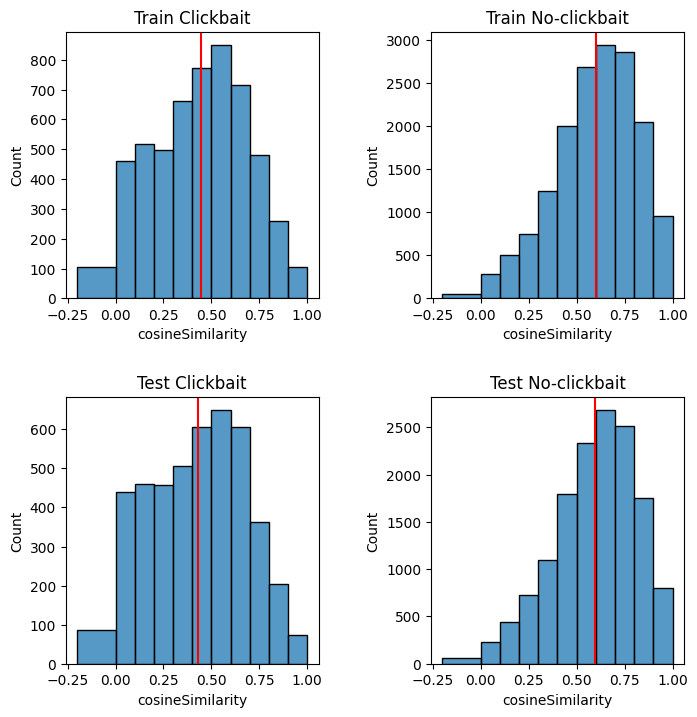

In [17]:
# plot distribution of cosine sim score for each of these 4
def get_hist():
    bins = [-0.2, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=5.0)
    
    sns.histplot(train_cb, x="cosineSimilarity", bins=bins, ax=axs[0][0]).set(title='Train Clickbait')
    axs[0][0].axvline(x=train_cb['cosineSimilarity'].mean(), color='red')

    sns.histplot(train_ncb, x="cosineSimilarity", bins=bins, ax=axs[0][1]).set(title='Train No-clickbait')
    axs[0][1].axvline(x=train_ncb['cosineSimilarity'].mean(), color='red')
    
    sns.histplot(test_cb, x="cosineSimilarity", bins=bins, ax=axs[1][0]).set(title='Test Clickbait')
    axs[1][0].axvline(x=test_cb['cosineSimilarity'].mean(), color='red')
    
    sns.histplot(test_ncb, x="cosineSimilarity", bins=bins, ax=axs[1][1]).set(title='Test No-clickbait')
    axs[1][1].axvline(x=test_ncb['cosineSimilarity'].mean(), color='red')

get_hist()

In [18]:
train_cb_d = train_cb.describe()
train_ncb_d = train_ncb.describe()
test_cb_d = test_cb.describe()
test_ncb_d = test_ncb.describe()

In [19]:
describe = pd.DataFrame()

describe['train_cb'] = train_cb_d
describe['test_cb'] = test_cb_d
describe['train_ncb'] = train_ncb_d
describe['test_ncb'] = test_ncb_d

describe

# threshold: 0.5, range 0.3-0.7

# 0.18 0.66 CB
# 0.35 0.77 NCB

train_cb      test_cb     train_ncb      test_ncb
count  5437.000000  4458.000000  16390.000000  14455.000000
mean      0.445961     0.431685      0.600542      0.596773
std       0.242838     0.245699      0.213359      0.212281
min      -0.114588    -0.183769     -0.115825     -0.125202
25%       0.255821     0.229393      0.465783      0.461908
50%       0.461289     0.446220      0.622012      0.619491
75%       0.624778     0.621974      0.759756      0.755810
max       1.000001     1.000000      1.000001      1.000000

### Test Accuracy

In [20]:
len(train_cb), len(train_ncb), len(test_cb), len(test_ncb)

(5437, 16390, 4458, 14455)

In [21]:
all_test = list(test_cb['cosineSimilarity'])
all_test.extend(list(test_ncb['cosineSimilarity']))

In [22]:
all_test_label = list(test_cb['truthClass'])
all_test_label.extend(list(test_ncb['truthClass']))

In [23]:
len(all_test), len(all_test_label), all_test[:3], all_test_label[:3]

(18913,
 18913,
 [0.3049447536468506, 0.252655029296875, 0.29198649525642395],
 ['clickbait', 'clickbait', 'clickbait'])

In [24]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]=='no-clickbait':
           TP += 1
        if y_pred[i]=='no-clickbait' and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]=='clickbait':
           TN += 1
        if y_pred[i]=='clickbait' and y_actual[i]!=y_pred[i]:
           FN += 1

    p = TP/(TP+FP)
    r = TP/(TP+FN)
    f = 2*p*r/(p+r)
    return f

In [25]:
def get_cls_report_with_threshold(threshold):
    result = []
    y_pred = []
    y_true = []
    del_idx = []
    
    for val in all_test:
        if val >= threshold:
            result.append('no-clickbait')
        else:
            result.append('clickbait')
   
    for i, e in enumerate(all_test_label):
        if e not in ['clickbait', 'no-clickbait']:
            del_idx.append(i)
    for i, e in enumerate(result):
        if i in del_idx:
            continue
        else:
            y_pred.append(e)
    for i, e in enumerate(all_test_label):
        if i in del_idx:
            continue
        else:
            y_true.append(e)

    print(perf_measure(y_true, y_pred))
#     print(y_true[:3], y_pred[:3])
#     print('F1 Score:', f1_score(y_true, y_pred, pos_label='no-clickbait'))
    print('Accuracy:', accuracy_score(y_true, y_pred))

In [72]:
# best threshold
get_cls_report_with_threshold(0.21)

0.8662250816087218
Accuracy: 0.7768201765981071


In [59]:
get_cls_report_with_threshold(0.15)

0.8698928749377179
Accuracy: 0.779093745043092


In [71]:
get_cls_report_with_threshold(0.29)

0.8548545276234063
Accuracy: 0.7652408396341142


In [70]:
get_cls_report_with_threshold(0.23)

0.8639193028378077
Accuracy: 0.7745994818378893


In [62]:
get_cls_report_with_threshold(0.17)

0.869268353796041
Accuracy: 0.7793052397821604


### Val Accuracy

In [63]:
all_val = list(train_cb['cosineSimilarity'])[-762:]
all_val.extend(list(train_ncb['cosineSimilarity'])[-1697:])

In [64]:
len(all_val)

2459

In [65]:
all_val_label = list(train_cb['truthClass'])[-762:]
all_val_label.extend(list(train_ncb['truthClass'])[-1697:])

In [66]:
len(all_val_label)

2459

In [67]:
def get_cls_report_with_threshold_val(threshold):
    result = []
    y_pred = []
    y_true = []
    del_idx = []
    
    for val in all_val:
        if val >= threshold:
            result.append('no-clickbait')
        else:
            result.append('clickbait')
   
    for i, e in enumerate(all_val_label):
        if e not in ['clickbait', 'no-clickbait']:
            del_idx.append(i)
    for i, e in enumerate(result):
        if i in del_idx:
            continue
        else:
            y_pred.append(e)
    for i, e in enumerate(all_val_label):
        if i in del_idx:
            continue
        else:
            y_true.append(e)

    print(perf_measure(y_true, y_pred))
#     print('F1 Score:', f1_score(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))

In [69]:
get_cls_report_with_threshold_val(0.17)

0.8085423392103303
Accuracy: 0.6864579097193981


### TSNE

In [ ]:
# original train cb vs ncb

cb_p = list(train_cb['postTextEmbedding'])
X_cb_p = TSNE(n_components=2).fit_transform(cb_p)

ncb_p = list(train_ncb['postTextEmbedding'])
X_ncb_p = TSNE(n_components=2).fit_transform(ncb_p)


/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
X_cb_p.shape, X_ncb_p.shape

In [100]:
df_X_cb_p = pd.DataFrame(X_cb_p)
df_X_cb_p.shape

(5437, 2)

In [101]:
df_X_ncb_p = pd.DataFrame(X_ncb_p)
df_X_ncb_p.shape

(16390, 2)

In [102]:
myx = pd.concat([df_X_ncb_p, df_X_cb_p])
myx.shape

(21827, 2)

In [103]:
lab = ['Train Clickbait']*5437
lab1 = ['Train Non-clickbait']*16390
lab1.extend(lab)

In [108]:

myx = myx.rename(columns={0:'x',1:'y'})
myx = myx.assign(label=lab1)

import plotly.express as px

fig = px.scatter(
    myx, x='x', y='y',
    color='label', labels={'color': 'label'},
    title = 'TSNE plot of GT Clickbait VS Non-clickbait Headlines')
fig.show()

In [107]:
# original train cb vs ncb

cb_p = list(train_cb['generatedPostTextEmbedding'])
X_cb_p = TSNE(n_components=2).fit_transform(cb_p)

ncb_p = list(train_ncb['generatedPostTextEmbedding'])
X_ncb_p = TSNE(n_components=2).fit_transform(ncb_p)


/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/charmichokshi4444/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [109]:
df_X_cb_p = pd.DataFrame(X_cb_p)
df_X_cb_p.shape

(5437, 2)

In [110]:
df_X_ncb_p = pd.DataFrame(X_ncb_p)
df_X_ncb_p.shape

(16390, 2)

In [111]:
myx = pd.concat([df_X_ncb_p, df_X_cb_p])
myx.shape

(21827, 2)

In [112]:
lab = ['Train Clickbait']*5437
lab1 = ['Train Non-clickbait']*16390
lab1.extend(lab)

In [113]:
myx = myx.rename(columns={0:'x',1:'y'})
myx = myx.assign(label=lab1)

import plotly.express as px

fig = px.scatter(
    myx, x='x', y='y',
    color='label', labels={'color': 'label'},
    title = 'TSNE plot of Generated Clickbait VS Non-clickbait Headlines')
fig.show()

In [ ]:
https://inside-machinelearning.com/en/efficient-sentences-embedding-visualization-tsne/
Euclidean distance

Decision Function:
0.5 0.7 0.8